# **Chapter 12**
## *Forecasting Using Supervised Machine Learning*, 

This chapter will take you from classical time series forecasting techniques to more advanced machine learning algorithms. The chapter shows how time series data can be transformed appropriately to be suitable for supervised machine learning. In addition, you will explore a variety of machine learning algorithms and implement multi-step forecasting, using both `scikit-learn` and `sktime`.


In this chapter, we will cover the following recipes:
* Preparing time series data for supervised learning
* One-step forecasting using linear regression models with scikit-learn
* Multi-step forecasting using linear regression models with scikit-learn
* Forecasting using non-linear models with sktime
* Optimizing a forecasting model with hyperparameter tuning
* Forecasting with exogenous variables and ensemble learning



# Technical Requirements

If you need a quick refresher on creating a virtual Python environment, check out the *Development environment setup* recipe, from **Chapter 1**, *Getting Started with Time Series Analysis*. The chapter covers two methods: using `conda` and `venv`.   

The following instructions will show how to create a virtual environment using conda. You can call the environment any name you like. For the following example, we will name the environment sktime: 

```
conda create -n sktime python=3.9 -y
conda activate sktime
conda install -c conda-forge sktime-all-extras
```
To make the new sktime environment visible within Jupyter, you can run the following code:

```
python -m ipykernel install —user —name sktime —display-name "sktime"
```

* To install using `pip`, run the following command:
```
pip install "sktime[all_extras]"
```


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')



In [2]:
import sktime
import statsmodels as sm
import matplotlib 
import sklearn

print(f'''
sktime ->  {sktime.__version__}
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
sklearn -> {sklearn.__version__}
statsmodels -> {sm.__version__}
''')


sktime ->  0.11.4
Matplotlib -> 3.5.2
pandas -> 1.4.2   
numpy -> 1.21.6
sklearn -> 1.1.1
statsmodels -> 0.13.2



In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [4]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

In [5]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [6]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [7]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [8]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

In [9]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

In [11]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [12]:
path = Path('../../datasets/Ch12/')
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [13]:
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [14]:
print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

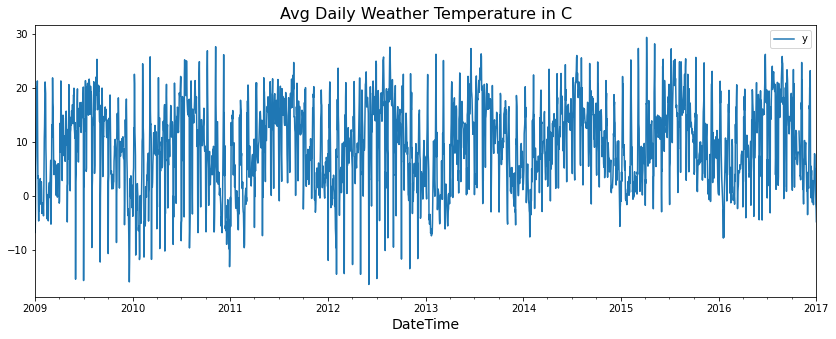

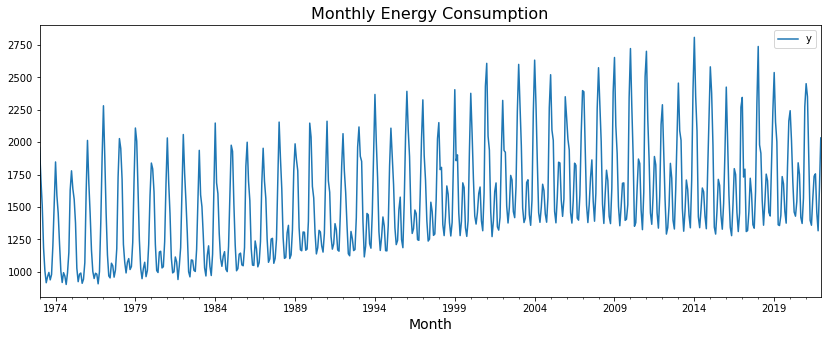

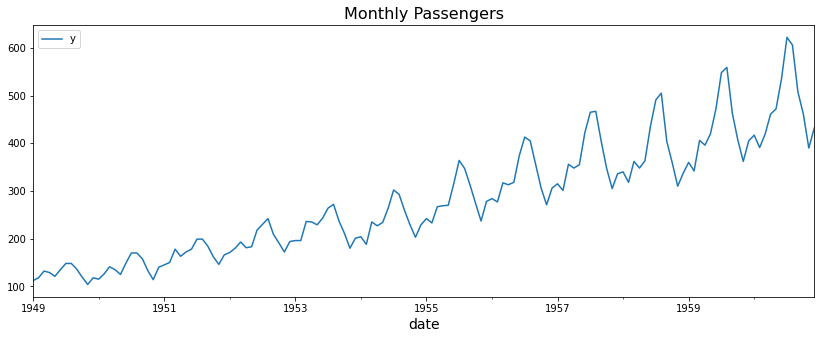

In [16]:
plt.rcParams["figure.figsize"] = [14, 5]  
daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

# Recipe 1. Preparing Time Series Data for Supervised Learning

In [17]:
air_copy = air.copy()
energy_copy = energy.copy()
daily_temp_copy = daily_temp.copy()

In [18]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

In [19]:
for df in [air_copy, energy_copy, daily_temp_copy]:
    handle_missing_data(df)

found 2 missing observations...


In [20]:
daily_temp_copy.isna().sum()

y    0
dtype: int64

In [21]:
air_os = one_step_forecast(air_copy, 5)
energy_os = one_step_forecast(energy_copy, 5)
daily_temp_os = one_step_forecast(daily_temp_copy, 5)
print(air_os.shape)
print(energy_os.shape)
print(daily_temp_os.shape)

(139, 6)
(583, 6)
(2918, 6)


In [22]:
air_os.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112,118,132,129,121,135
1949-02-28,118,132,129,121,135,148
1949-03-31,132,129,121,135,148,148
1949-04-30,129,121,135,148,148,136
1949-05-31,121,135,148,148,136,119


In [23]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [24]:
train, test = split_data(air_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 119 Test: 20


In [25]:
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,-1.401933,-1.364908,-1.240908,-1.294771,-1.398791,-1.273682
1949-02-28,-1.338755,-1.216817,-1.272708,-1.379791,-1.250613,-1.136238
1949-03-31,-1.191342,-1.248551,-1.357508,-1.231006,-1.113020,-1.136238
1949-04-30,-1.222930,-1.333174,-1.209108,-1.092848,-1.113020,-1.263109
1949-05-31,-1.307167,-1.185083,-1.071309,-1.092848,-1.240029,-1.442843


In [26]:
y_train_original = scaler.inverse_y(train_s['y'])

In [27]:
train_original = scaler.inverse(train_s)
train_original.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0


## There is more

In [28]:
df = daily_temp.copy()

In [29]:
df['day_of_week'] = df.index.dayofweek
df['days_in_month'] = df.index.days_in_month
df['month_end'] = df.index.is_month_end.astype(int)
df['is_leap'] = df.index.is_leap_year.astype(int)
df['month'] = df.index.month
df.head()

,y,day_of_week,days_in_month,month_end,is_leap,month
DateTime,,,,,,
2009-01-01,-6.810629,3,31,0,0,1
2009-01-02,-3.360486,4,31,0,0,1
2009-01-03,5.435694,5,31,0,0,1
2009-01-04,7.283889,6,31,0,0,1
2009-01-05,12.690069,0,31,0,0,1


# Recipe 2. One-Step Forecasting using Linear Regression Models with Scikit-Learn

## How to do it..

In [30]:
from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor)

In [31]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

### Preprocessing Time Series Data

In [32]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [33]:
air_reg = one_step_forecast(air_cp, 10)
en_reg = one_step_forecast(en_cp, 10)
dw_reg = one_step_forecast(dw_cp, 10)

In [34]:
print(air_reg.shape)
print(en_reg.shape)
print(dw_reg.shape)

(134, 11)
(578, 11)
(2913, 11)


In [35]:
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [36]:
train_air, test_air = split_data(air_reg, test_split=0.10)
scaler_air = Standardize()
train_air_s, test_air_s = scaler_air.fit_transform(train_air,test_air)

In [37]:
train_en, test_en = split_data(en_reg, test_split=0.10)
scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)

In [38]:
train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

### Train

In [39]:
regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

In [40]:
air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


### Evaluate

In [41]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
air_results = pd.DataFrame(air_results)
air_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
2,Ridge Regression,0.381092,0.210168,1.390807
0,Linear Regression,0.385559,0.213810,1.411072
4,Huber Regression,0.400949,0.226859,1.457932
1,Elastic Net,0.829023,0.406390,2.808737
3,Lasso Regression,1.190006,0.780255,4.439302


In [42]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.431651,0.729910,0.525526
2,Ridge Regression,0.433192,0.819432,0.560450
0,Linear Regression,0.433747,0.818459,0.560989
1,Elastic Net,0.747657,1.398025,1.013425
3,Lasso Regression,0.834356,1.502494,1.108092


In [43]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.655729,0.697774,0.968735
0,Linear Regression,0.646648,0.735055,0.990057
2,Ridge Regression,0.646639,0.735072,0.990085
1,Elastic Net,0.737896,1.075669,1.300792
3,Lasso Regression,0.814609,1.304278,1.468567


#### Air Passengers Plots

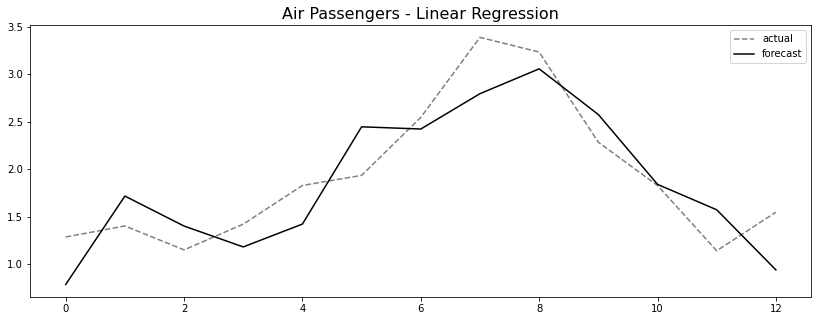

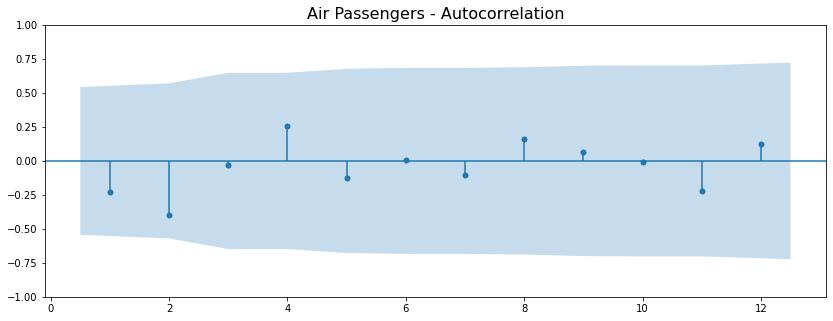

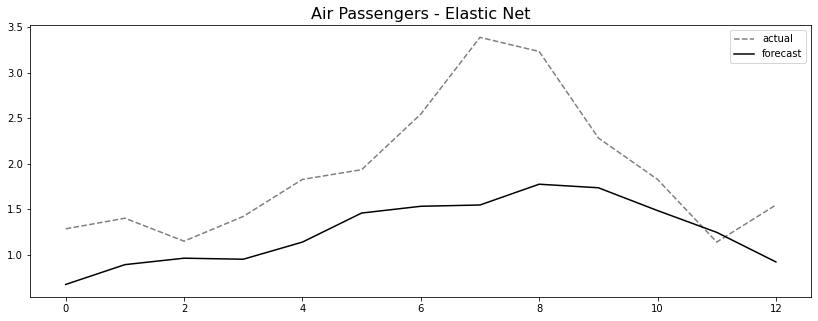

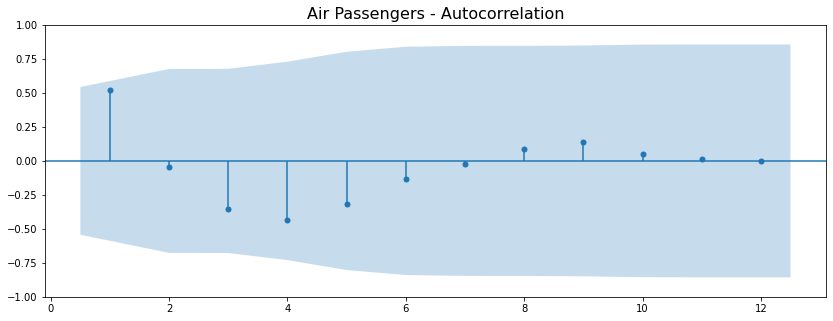

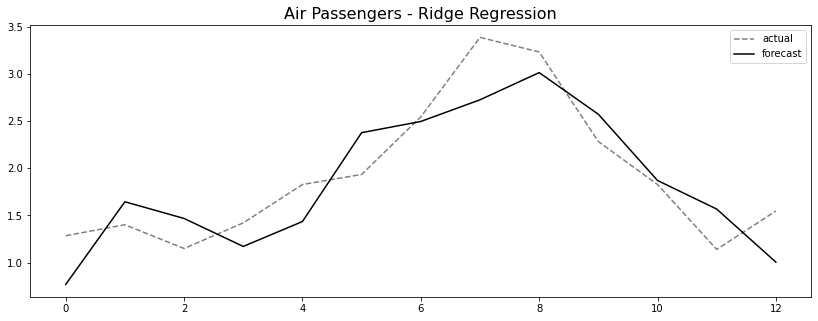

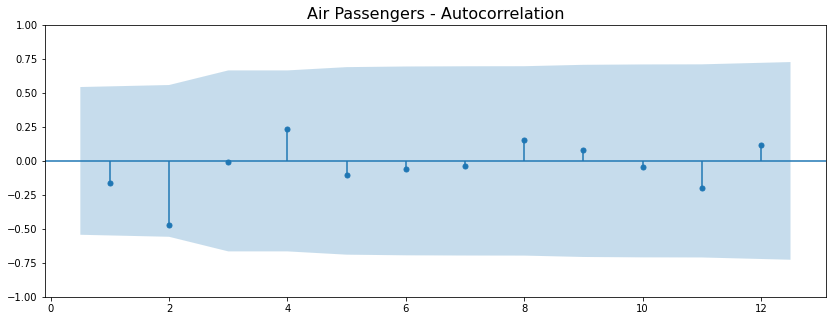

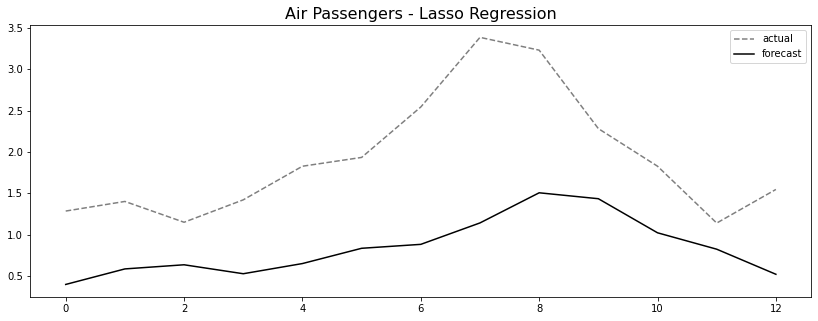

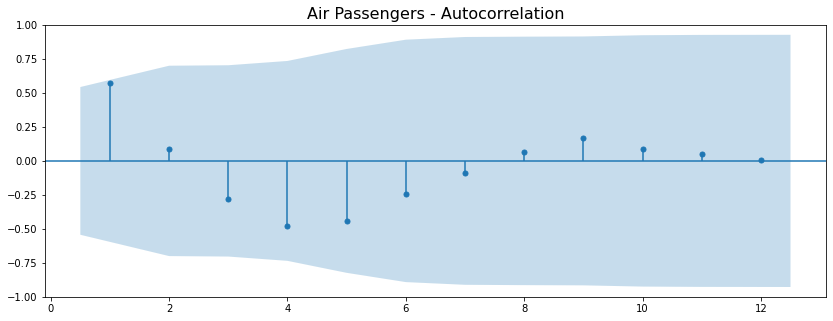

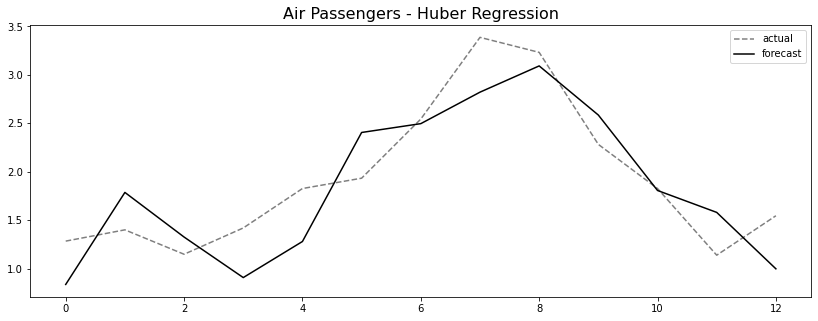

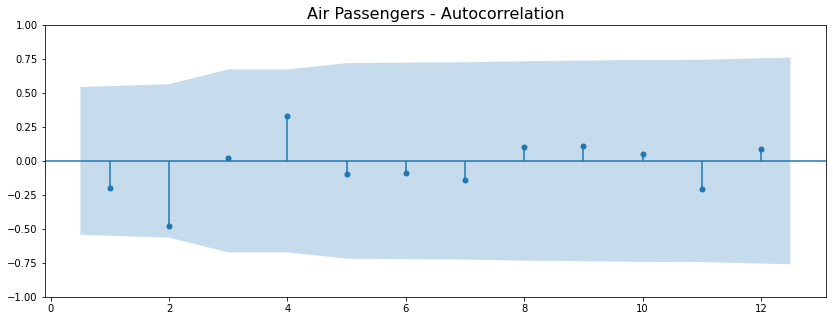

In [44]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, air_results, 'Air Passengers')


#### Energy Consumption Plots

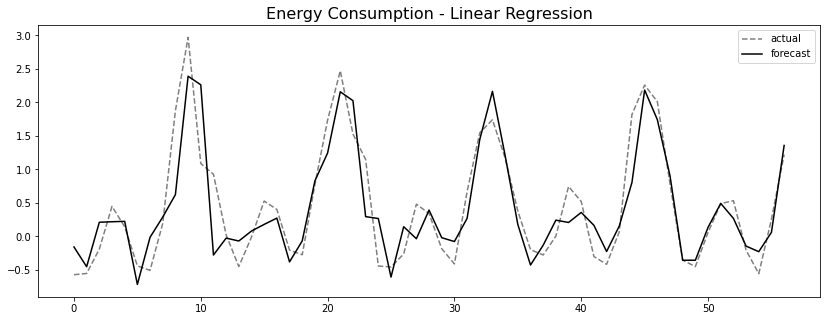

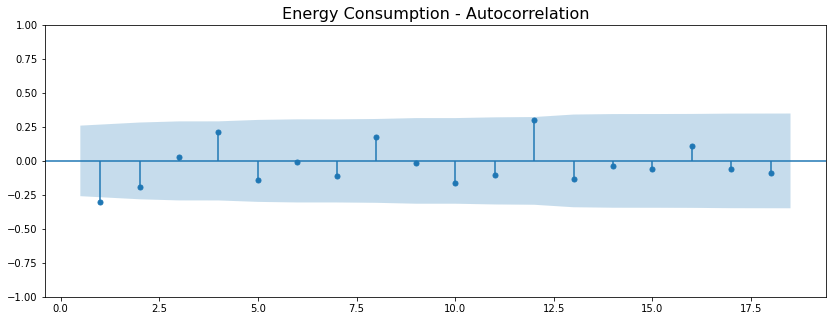

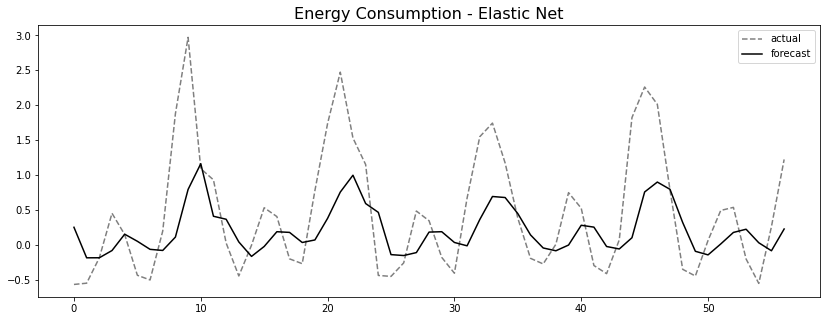

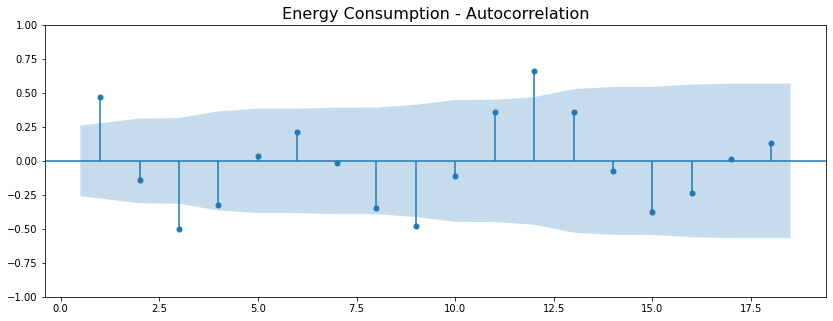

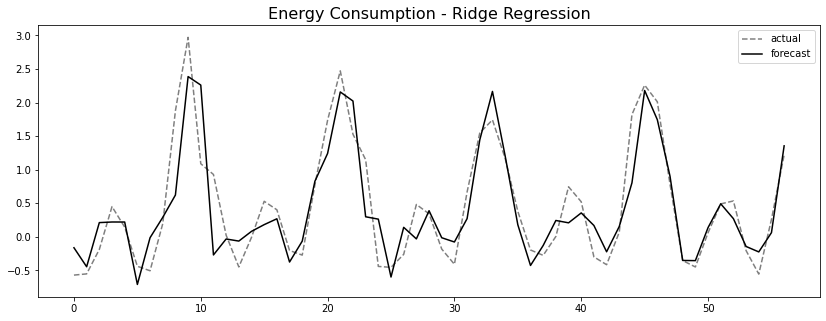

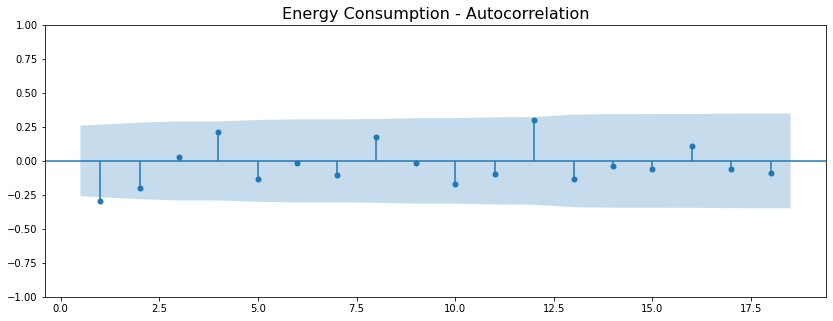

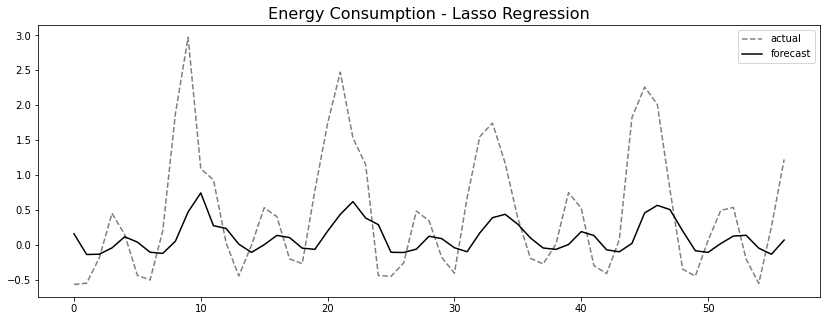

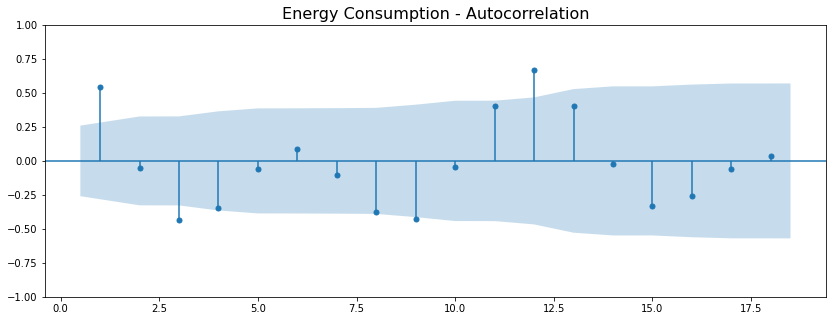

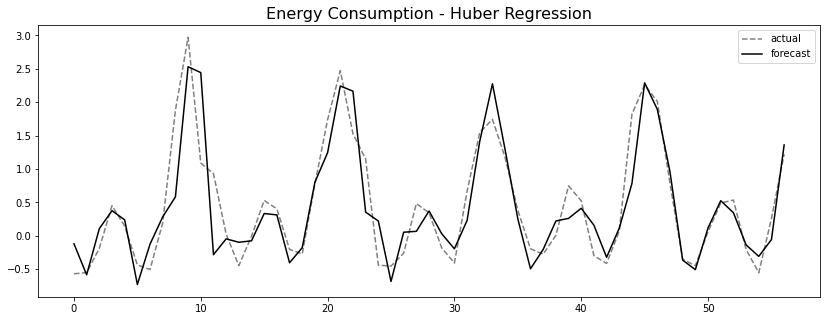

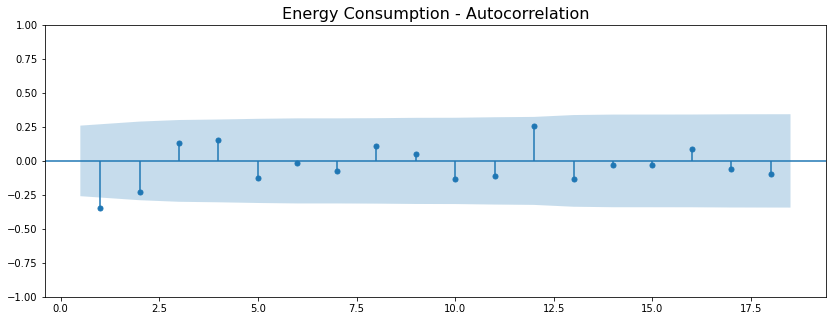

In [45]:
plot_results(cols, en_results, 'Energy Consumption')

#### Daily Temperature Plots

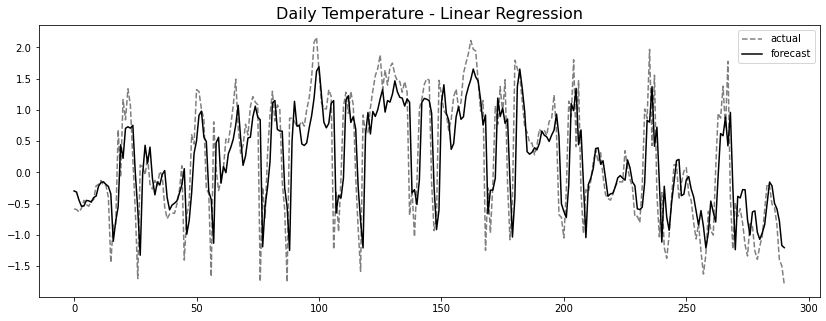

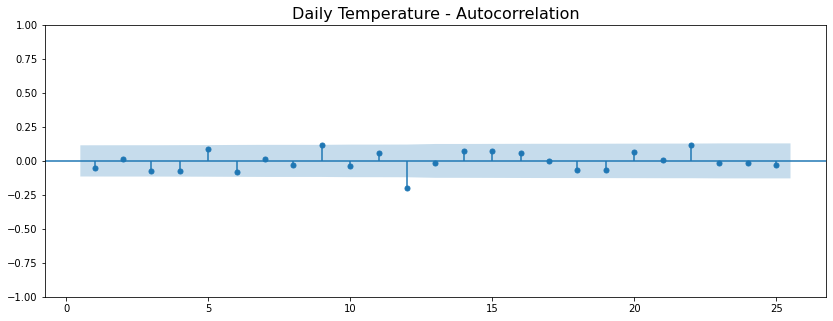

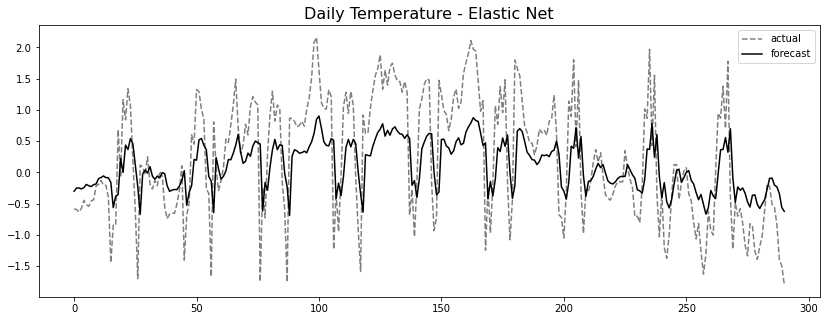

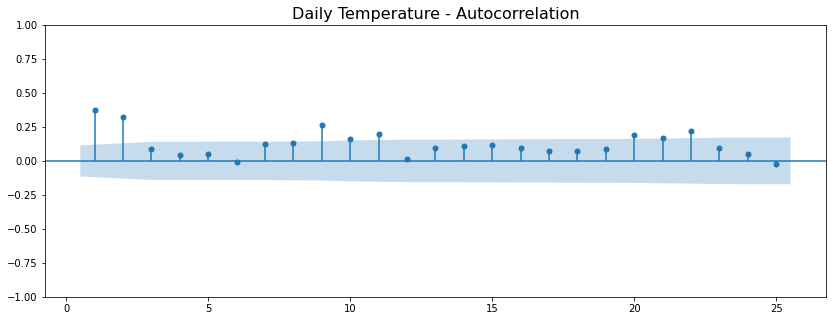

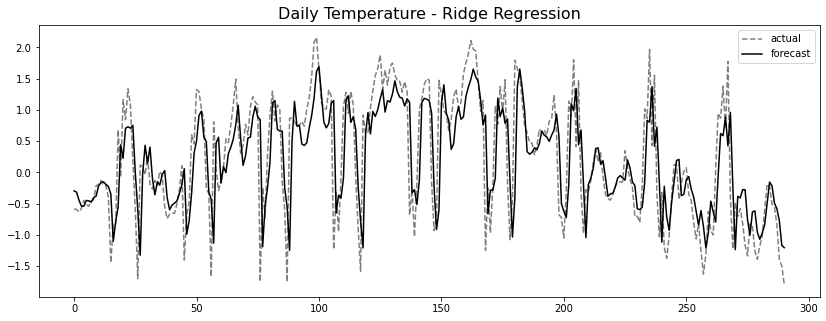

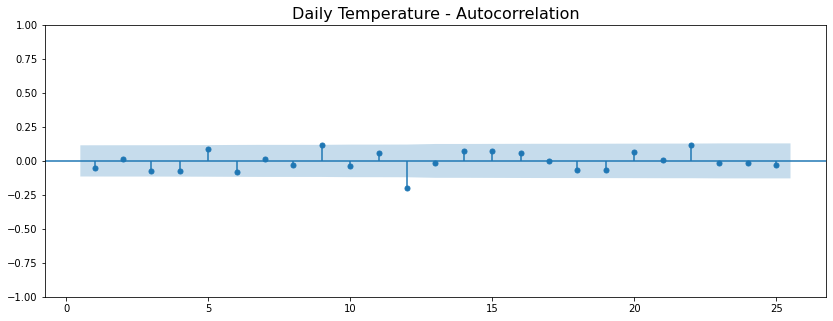

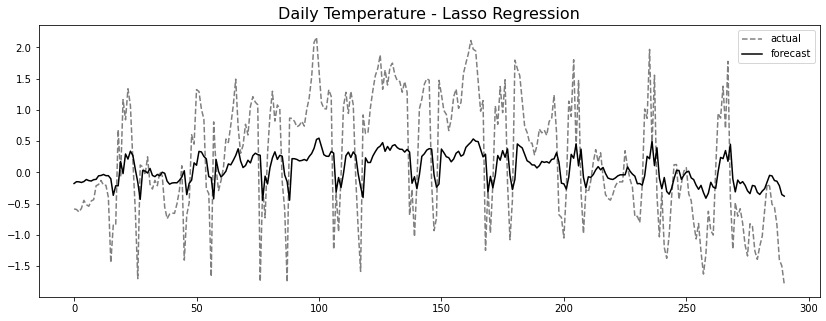

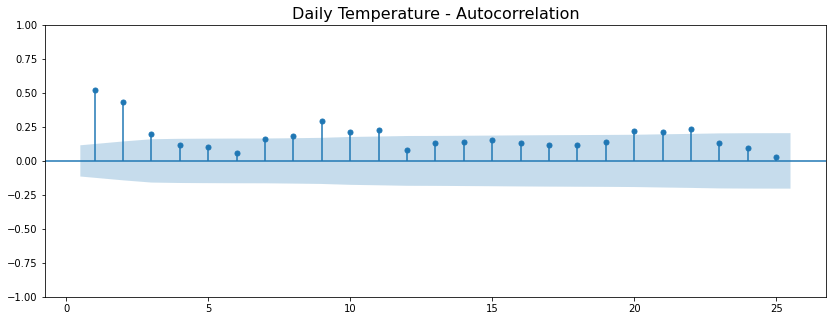

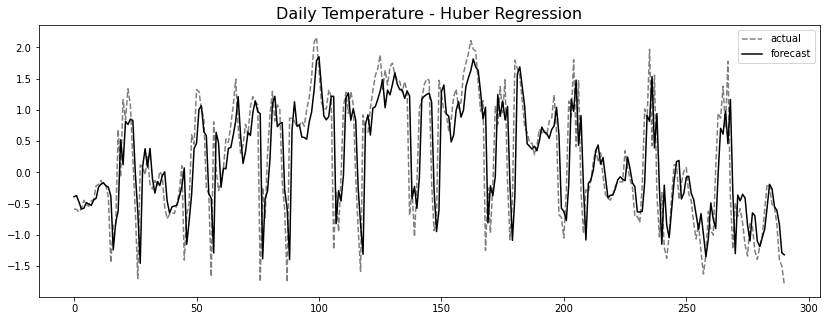

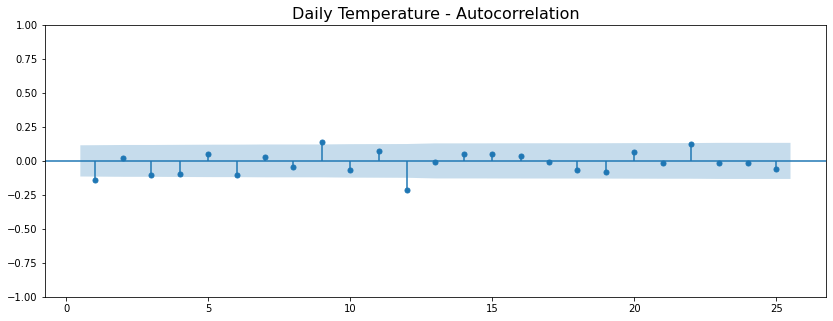

In [46]:
plot_results(cols, dw_results, 'Daily Temperature')

## How it works

In [47]:
cols = ['Model Name', 'Model']
en_models = en_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.02739136  0.02052173  0.03768302  0.06630472  0.01417452 -0.08727704
  0.02856578 -0.13640839  0.14165493  0.70683461]
Elastic Net
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04077799 0.37835549]
Ridge Regression
[ 0.0273999   0.02054709  0.0377177   0.06625515  0.01414968 -0.08721396
  0.02844889 -0.13622568  0.14175768  0.7065417 ]
Lasso Regression
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2536153]


### Energy Consumption

**Regression Coefficients and Feature Selection**

In [48]:
en_10 = en_reg[['y', 'x_10']]

train_en10, test_en10 = split_data(en_10, test_split=0.10)
scaler_en10 = Standardize()
train_en10_s, test_en10_s = scaler_en.fit_transform(train_en10, test_en10)

en_10_results = train_different_models(train_en10_s, test_en10_s, regressors)

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_10_results = pd.DataFrame(en_results)
en_10_results[cols].sort_values('MASE')

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.431651,0.729910,0.525526
2,Ridge Regression,0.433192,0.819432,0.560450
0,Linear Regression,0.433747,0.818459,0.560989
1,Elastic Net,0.747657,1.398025,1.013425
3,Lasso Regression,0.834356,1.502494,1.108092


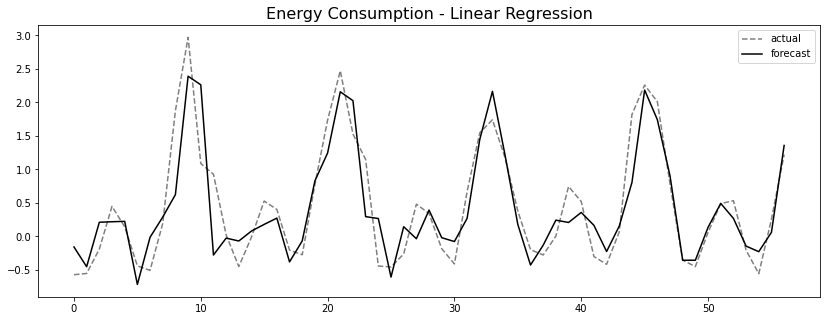

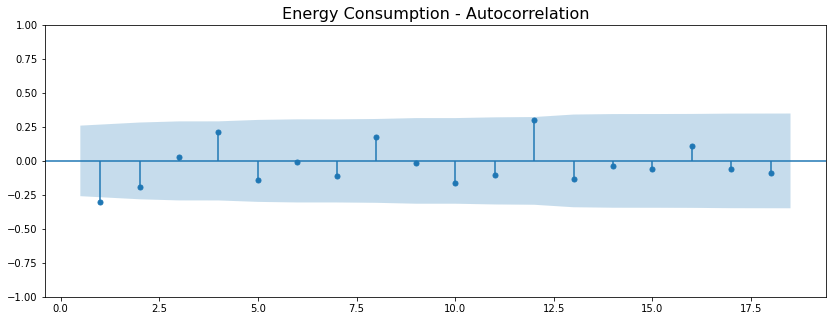

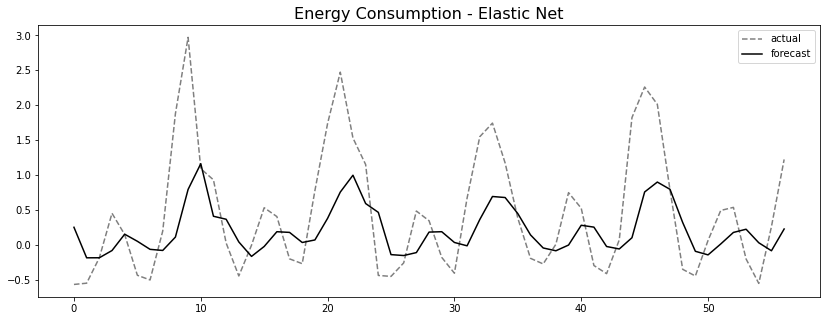

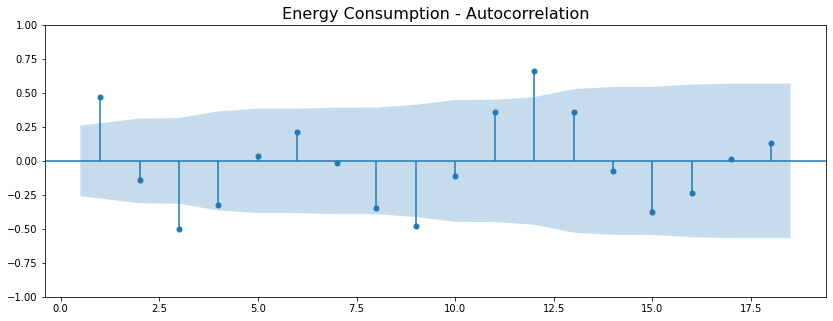

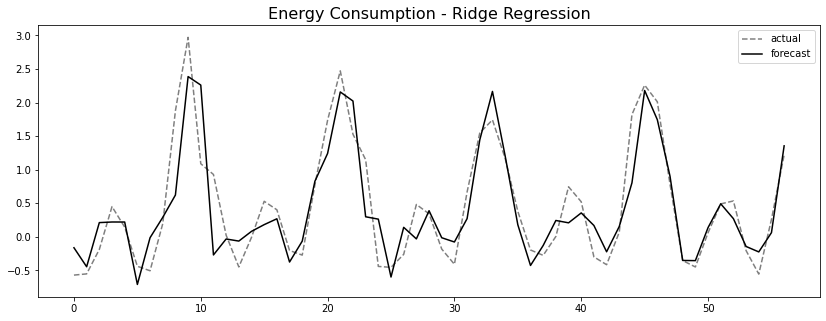

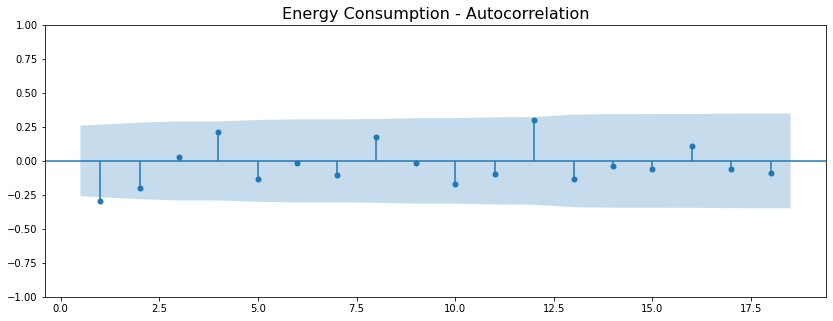

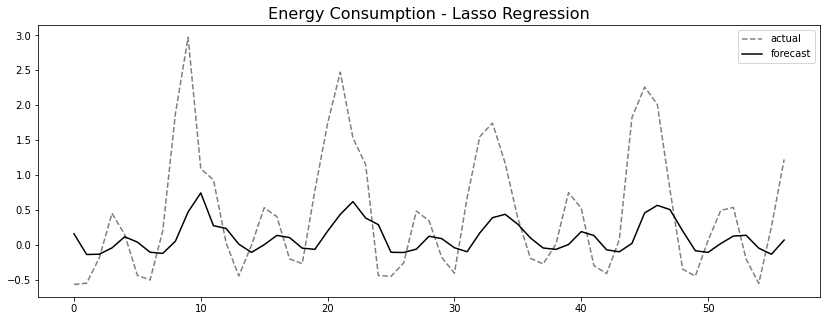

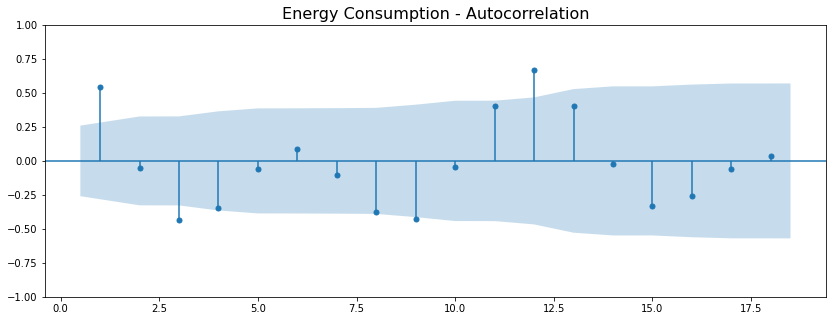

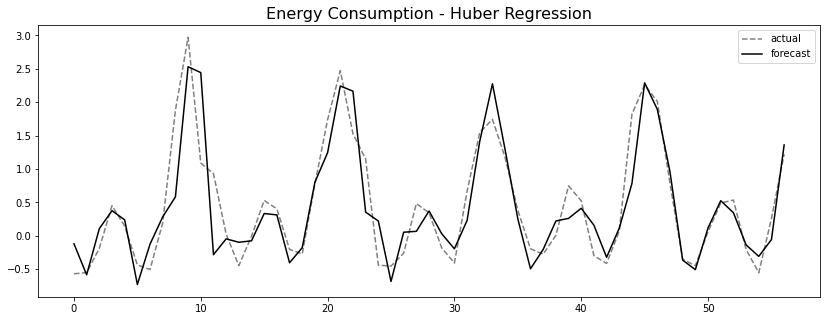

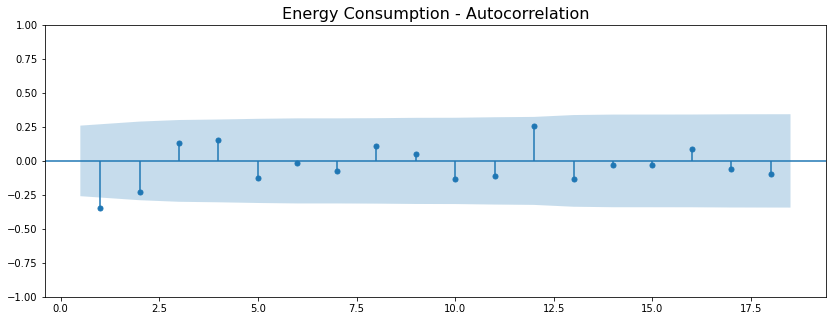

In [49]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, en_10_results, 'Energy Consumption')

In [50]:
cols = ['Model Name', 'Model']
en_models = en_10_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[0.75051783]
Elastic Net
[0.39987585]
Ridge Regression
[0.74979687]
Lasso Regression
[0.24955629]


# Recipe 3. Multi-Step Forecasting using Linear Regression Models with Scikit-Learn

In [51]:
air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

air_results = pd.DataFrame(air_results)
en_results = pd.DataFrame(en_results)
dw_results = pd.DataFrame(dw_results)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [52]:
dw_results

,Model Name,Model,RMSE,MAPE,MASE,yhat,resid,actual
0,Linear Regression,LinearRegression(fit_intercept=False),0.646648,0.735055,0.990057,"[-0.296192538652388, -0.3145139435480655, -0.4...","[-0.288032218288152, -0.278722523215016, -0.19...","[-0.58422475694054, -0.5932364667630815, -0.63..."
1,Elastic Net,"ElasticNet(alpha=0.5, fit_intercept=False)",0.737896,1.075669,1.300792,"[-0.3018190700137871, -0.24968002141505866, -0...","[-0.2824056869267529, -0.3435564453480229, -0....","[-0.58422475694054, -0.5932364667630815, -0.63..."
2,Ridge Regression,"Ridge(alpha=0.5, fit_intercept=False)",0.646639,0.735072,0.990085,"[-0.2961387027588529, -0.31441772053786077, -0...","[-0.2880860541816871, -0.27881874622522074, -0...","[-0.58422475694054, -0.5932364667630815, -0.63..."
3,Lasso Regression,"Lasso(alpha=0.5, fit_intercept=False)",0.814609,1.304278,1.468567,"[-0.1768781411197204, -0.14827924485769844, -0...","[-0.4073466158208196, -0.44495722190538306, -0...","[-0.58422475694054, -0.5932364667630815, -0.63..."
4,Huber Regression,HuberRegressor(fit_intercept=False),0.655729,0.697774,0.968735,"[-0.38904409394013917, -0.3699976860875043, -0...","[-0.19518066300040082, -0.22323878067557723, -...","[-0.58422475694054, -0.5932364667630815, -0.63..."


In [53]:
test_dw_s.iloc[[-1]]

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
DateTime,,,,,,,,,,,
2016-12-22,-1.180203,-1.022581,-0.604237,-0.189764,-0.224464,-0.514589,-0.559203,-0.839812,-1.397096,-1.496642,-1.792546


In [54]:
models = dw_results[['Model Name','Model']]
models

,Model Name,Model
0,Linear Regression,LinearRegression(fit_intercept=False)
1,Elastic Net,"ElasticNet(alpha=0.5, fit_intercept=False)"
2,Ridge Regression,"Ridge(alpha=0.5, fit_intercept=False)"
3,Lasso Regression,"Lasso(alpha=0.5, fit_intercept=False)"
4,Huber Regression,HuberRegressor(fit_intercept=False)


In [ ]:
# another version using NumPy
# def multi_step_forecast(data, model, steps=10):
#     forecast = []
#     for i in range(steps):
#         one_step_pred = model.predict(data.reshape(1,-1))[0]
#         forecast.append(one_step_pred)
#         data = np.roll(data, shift=-1)
#         data[-1] = one_step_pred
#     return np.array(forecast)

In [55]:
def multi_step_forecast(data, model, steps=10):
    forecast = []
    for i in range(steps):
        one_step_pred = model.predict(np.array(data).reshape(1,-1))[0]
        forecast.append(one_step_pred)
        _ = data.pop(0)
        data.append(one_step_pred)
    return np.array(forecast)

### Daily Temperature

In [56]:
frcst_dw = {}
models = dw_results[['Model Name','Model']]
dw_ms = test_dw_s.drop(columns=['y']).iloc[-1].tolist()

for i in models.iterrows():
    pred = multi_step_forecast(dw_ms, steps=10, model=i[1]['Model'])
    pred = scaler_dw.inverse_y(pred)
    frcst_dw[i[1]['Model Name']] = pred    

### Air Passengers

In [57]:
models = air_results[['Model Name','Model']]
air_ms = test_air.drop(columns=['y']).iloc[-1].tolist()
frcst_air = {}
for i in models.iterrows():
    pred = multi_step_forecast(air_ms, steps=10, model=i[1]['Model'])
    pred = scaler_air.inverse_y(pred)
    frcst_air[i[1]['Model Name']] = pred   

### Energy Consumption

In [58]:
models = en_results[['Model Name','Model']]
en_ms = test_en_s.drop(columns=['y']).iloc[-1].tolist()
frcst_en = {}
for i in models.iterrows():
    pred = multi_step_forecast(en_ms, steps=10, model=i[1]['Model'])
    pred = scaler_en.inverse_y(pred)
    frcst_en[i[1]['Model Name']] = pred   

#### Example on Daily Temperature Data

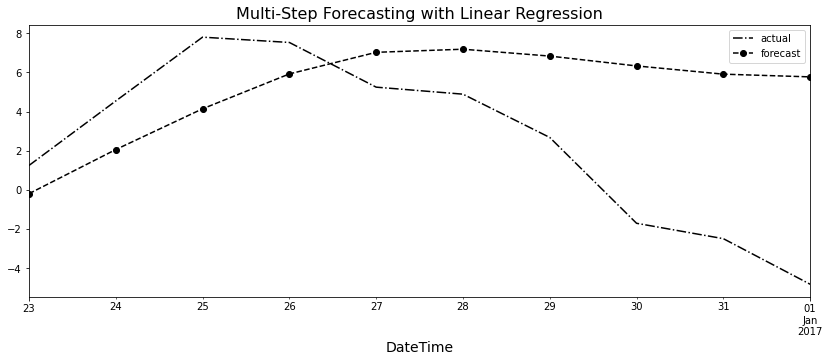

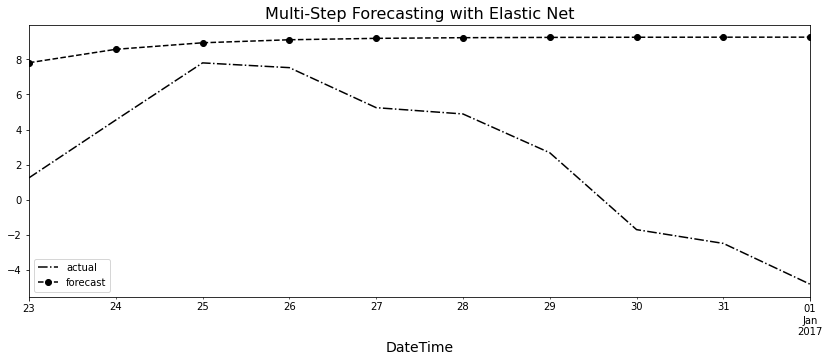

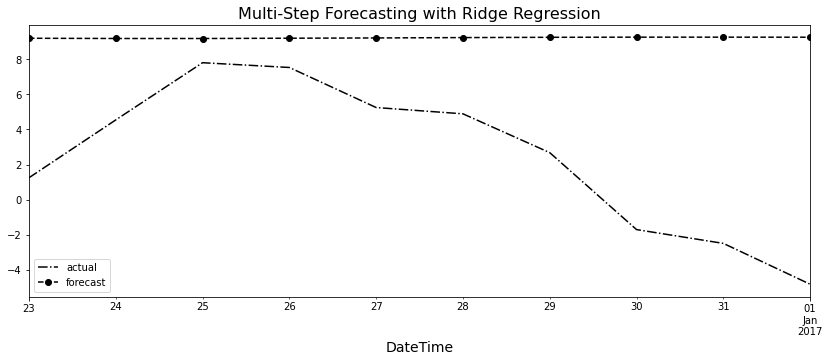

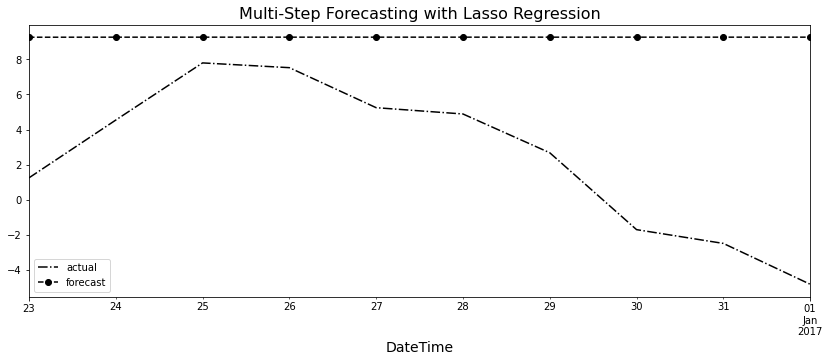

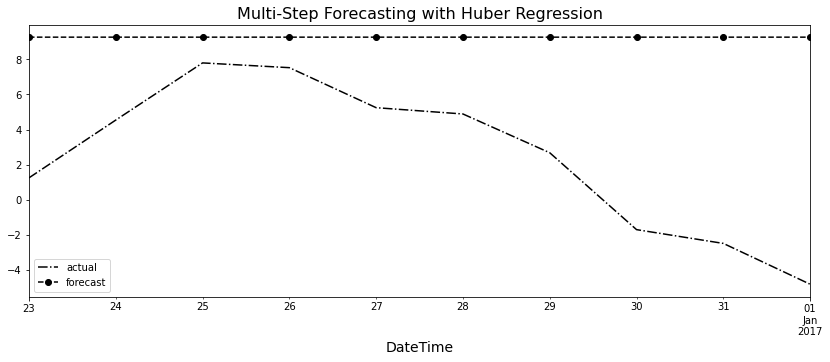

In [59]:
for name, pred in frcst_dw.items():
    actual = dw_cp.iloc[-10:]
    ax = actual.plot(style='k-.')
    pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
    plt.title(f'Multi-Step Forecasting with {name}')
    plt.legend(['actual', 'forecast'])
    plt.show()

## There is more

In [60]:
def multiple_output(df, window_in, window_out):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    print(len(idx))
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [61]:
win_in, win_out = 10, 10
dw_mo = multiple_output(dw_cp, win_in, win_out)

train_dw, test_dw = split_data(dw_mo, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

2913


In [62]:
dw_mo.columns

Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10',
       'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10'],
      dtype='object')

In [63]:
train_dw_s.shape

(2614, 20)

In [64]:
lr = LinearRegression()

In [65]:
X_train, y_train = train_dw_s.iloc[: , :win_in], train_dw_s.iloc[:, win_out:]
X_test, y_test = test_dw_s.iloc[: , :win_in], test_dw_s.iloc[:, win_out:]

In [66]:
lr.fit(X_train, y_train)

LinearRegression()

In [67]:
mo_pred = scaler_dw.inverse_y(lr.predict(X_test)[-1])
dates = pd.date_range('2016-12-13', freq='D', periods=20)
inputs, outputs = dates[:win_in], dates[win_out:]

In [68]:
test_dw.iloc[-1].values.shape

(20,)

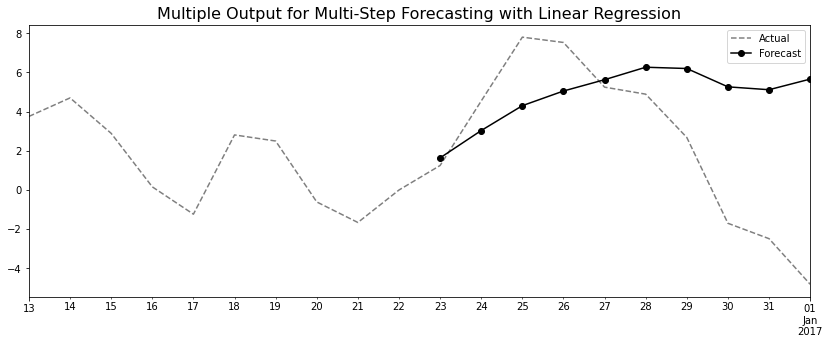

In [69]:
pd.Series(test_dw.iloc[-1].values, index=dates).plot(style='k--', alpha=0.5)
pd.Series(mo_pred, index=outputs).plot(style='k-o')
plt.title('Multiple Output for Multi-Step Forecasting with Linear Regression')
plt.legend(['Actual', 'Forecast'])
#plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.10.png', bbox_inches='tight', dpi=600)

# Recipe 4. Forecasting using Non-Linear Models with sktime

Loading required modules

In [70]:
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.all import (
        Deseasonalizer, Detrender, 
        temporal_train_test_split,
        mean_absolute_percentage_error as mape, 
        mean_squared_percentage_error as mspe,
        mean_squared_error as mse, 
        ForecastingHorizon, 
        NaiveForecaster,
        TransformedTargetForecaster,
        PolynomialTrendForecaster
)
from sktime.forecasting.compose import make_reduction


In [71]:
import sktime
sktime.__version__

'0.11.4'

Loading the dataset and inspecting the data

In [72]:
df = energy.copy()

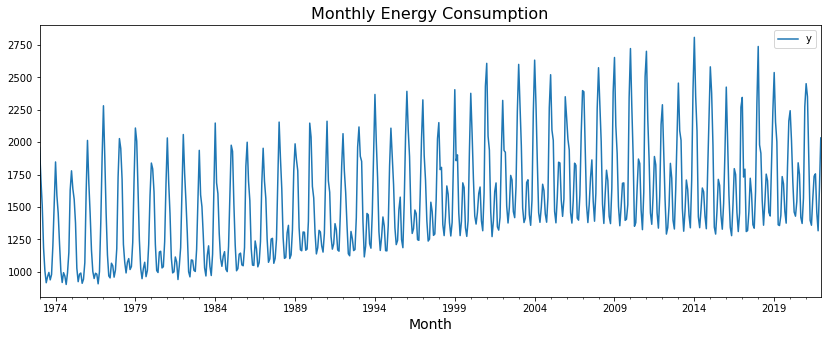

In [73]:
df.plot(title='Monthly Energy Consumption');plt.show()

In [74]:
df.head()

,y
Month,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326


In [75]:
df.tail()

,y
Month,
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799
2021-11-01,1644.306
2021-12-01,2032.352


In [76]:
df.index.year.unique()

Int64Index([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
            1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
            1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='Month')

In [77]:
df.shape

(588, 1)

**Different ways to split your time series**


In [78]:
train, test = split_data(df)

In [79]:
train.shape

(500, 1)

In [80]:
test.shape

(88, 1)

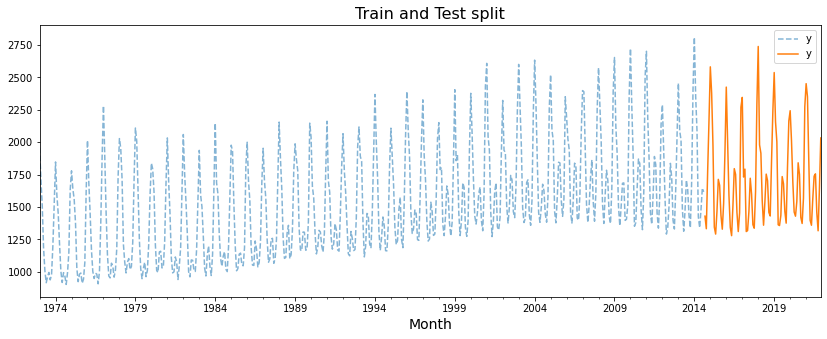

In [81]:
ax = train.plot(style='--', alpha=0.55)
test.plot(ax=ax)
plt.title('Train and Test split')
plt.show()

In [82]:
test.shape

(88, 1)

In [83]:
test.tail()

,y
Month,
2021-08-01,1755.212
2021-09-01,1456.901
2021-10-01,1315.799
2021-11-01,1644.306
2021-12-01,2032.352


In [84]:
from statsmodels.tsa.api import seasonal_decompose, adfuller

In [85]:
adfuller(df)

(-1.449733113243752,
 0.5582151234544165,
 12,
 575,
 {'1%': -3.4417738839904657,
  '5%': -2.8665796253604015,
  '10%': -2.569453974291115},
 6916.6482184861825)

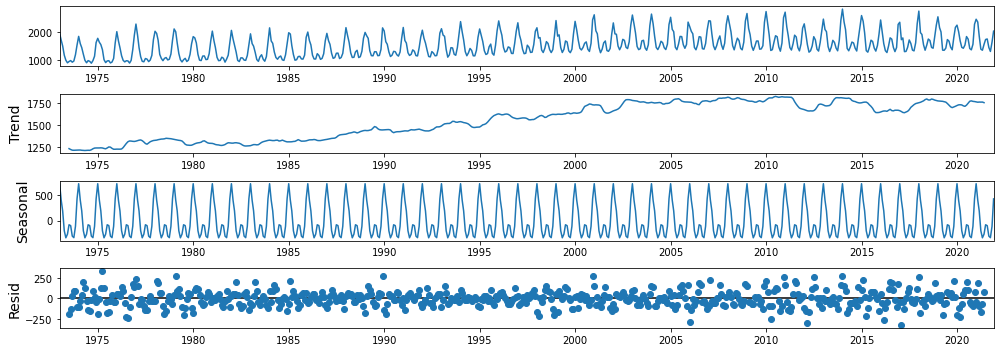

In [86]:
decomposed = seasonal_decompose(df)
decomposed.plot();

In [87]:
test.index

DatetimeIndex(['2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
      

In [88]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    forecaster = [
            ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))]
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor,
            strategy='recursive',
            window_length=window,
            scitype='tabular-regressor'))
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
        
    else:
        model = regressor.fit(data.values)
    
    predicted = pd.Series(
            model.predict(fh=fh).reshape(-1),
            index= test.index
                    )
    return predicted

In [89]:
make_reduction(lr)

RecursiveTabularRegressionForecaster(estimator=LinearRegression())

In [90]:
regressors = {
            'Naive Forecaster' : NaiveForecaster(strategy='mean', sp=12),
            'Linear Regression': LinearRegression(),
            'K-NN Regressor': KNeighborsRegressor(n_neighbors=5),
            'Extra Tree Regressor': ExtraTreesRegressor(),
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
            }

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg , window=15)

training NaiveForecaster(sp=12, strategy='mean') ...
training LinearRegression() ...
training KNeighborsRegressor() ...
training ExtraTreesRegressor() ...
training RandomForestRegressor() ...
training GradientBoostingRegressor() ...


In [91]:
test.shape

(88, 7)

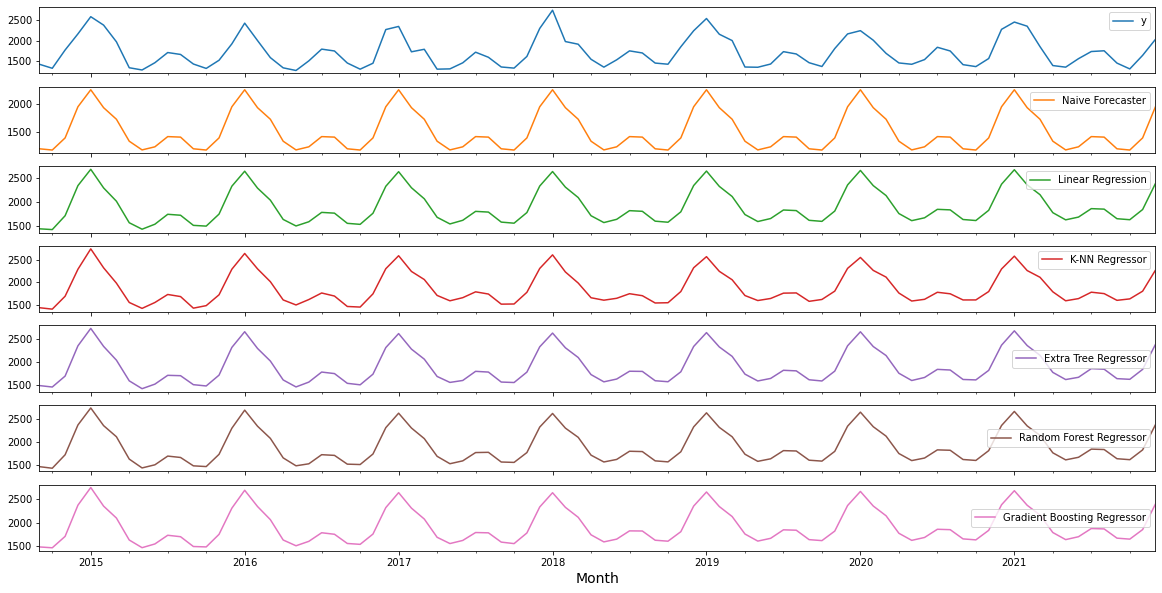

In [92]:
test.plot(subplots=True, figsize=(20, 10));plt.show()

<AxesSubplot:xlabel='Month'>

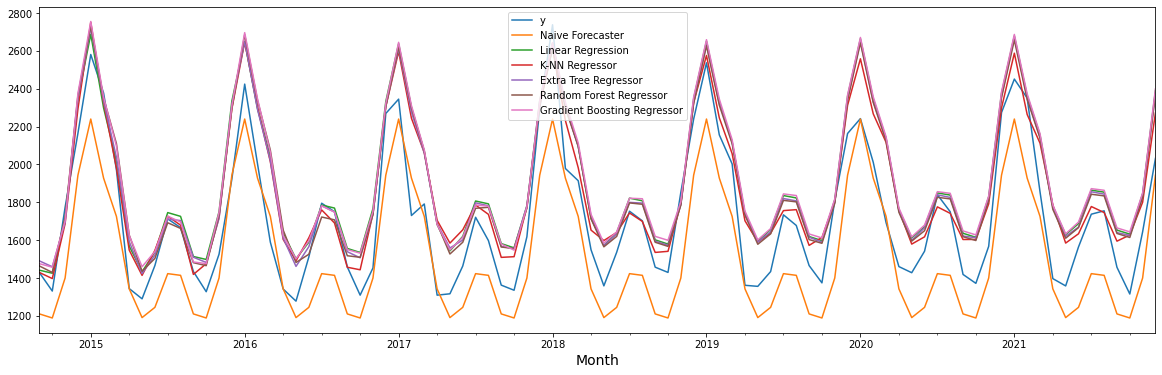

In [93]:
test.plot(subplots=False, figsize=(20, 6))

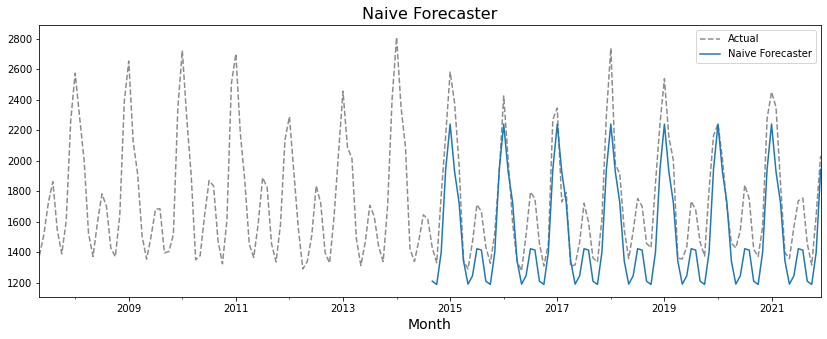

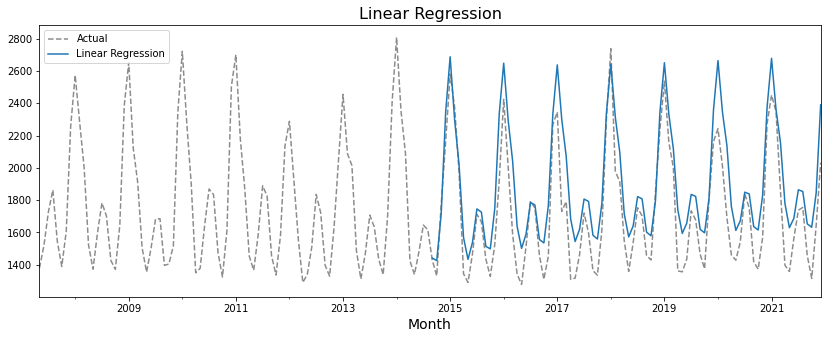

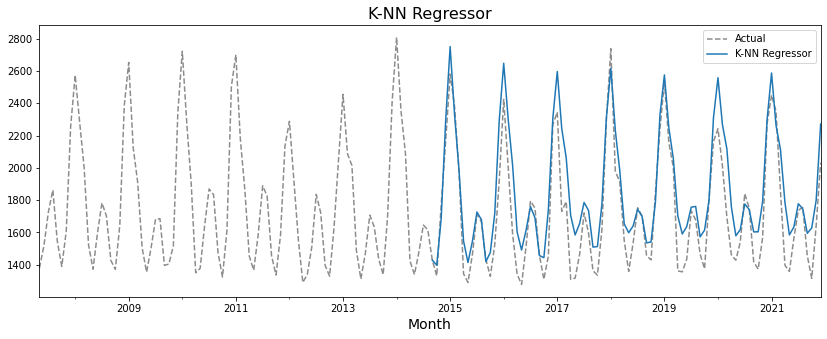

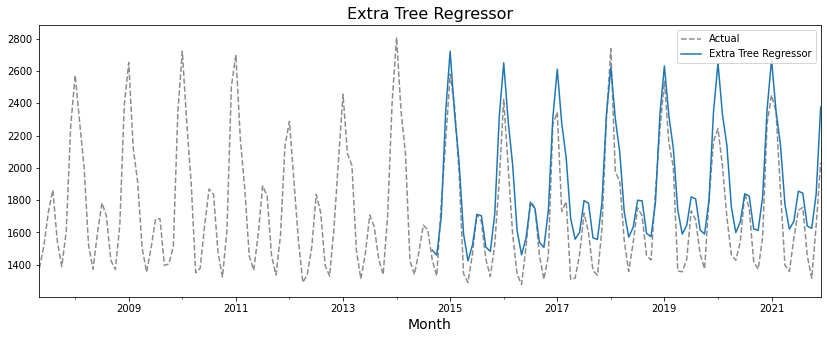

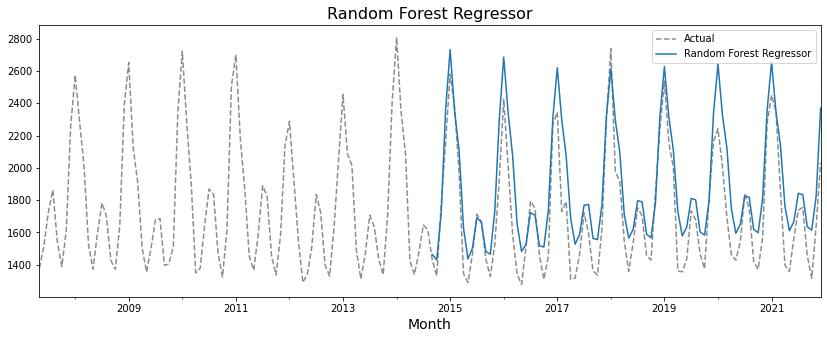

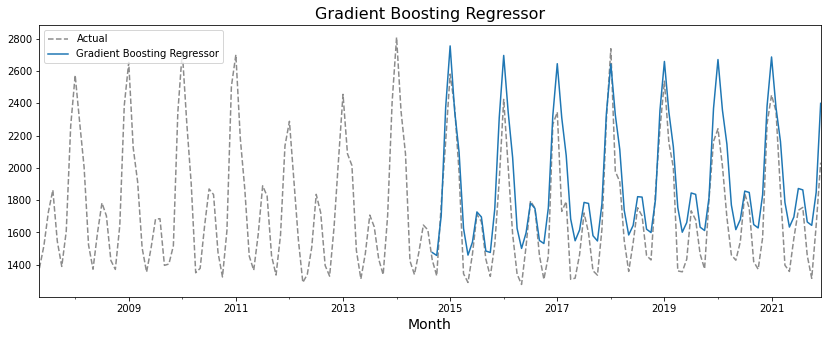

In [94]:
for i in test.iloc[: , 1:]:
    ax = df[-2*len(test):].plot(style='k--', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

In [95]:
test

,y,Naive Forecaster,Linear Regression,K-NN Regressor,Extra Tree Regressor,Random Forest Regressor,Gradient Boosting Regressor
Month,,,,,,,
2014-09-01,1428.555,1210.663512,1441.612460,1429.364383,1490.658089,1463.747793,1475.804086
2014-10-01,1331.478,1189.233073,1425.604618,1397.392401,1459.693439,1429.621084,1457.550039
2014-11-01,1773.932,1400.315878,1715.650462,1686.999710,1695.054823,1720.596420,1703.186602
2014-12-01,2164.807,1943.541073,2346.454781,2293.247940,2347.015036,2364.742190,2374.981222
2015-01-01,2580.929,2239.992643,2687.958228,2751.156269,2722.190207,2732.724541,2755.411366
...,...,...,...,...,...,...,...
2021-08-01,1755.212,1414.440881,1853.913756,1746.050685,1843.489708,1834.165564,1863.734586
2021-09-01,1456.901,1210.663512,1653.305608,1594.985762,1640.088894,1635.557549,1664.976452
2021-10-01,1315.799,1189.233073,1632.237707,1627.545921,1625.533146,1614.461117,1644.048373


In [96]:
def evaluate(df, train, sort_by='MASE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['y']
    y_predicted = df.drop(columns=['y'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
        evals.loc['MASE', p] = mase(y_truth, y_predicted[p], y_train=train)
    return evals.T.sort_values(by=sort_by)
    

In [97]:
evaluate(test, train)

,sMAPE,MAPE,RMSE,MASE
K-NN Regressor,0.088718,0.095485,192.449319,0.685551
Random Forest Regressor,0.099717,0.107578,211.273208,0.781959
Extra Tree Regressor,0.101217,0.109138,210.895741,0.790598
Linear Regression,0.105661,0.114187,219.063673,0.828132
Gradient Boosting Regressor,0.109237,0.118279,226.476401,0.859934
Naive Forecaster,0.133619,0.123643,242.222293,0.957688


In [98]:
evaluate(test, train, sort_by='RMSE')

,sMAPE,MAPE,RMSE,MASE
K-NN Regressor,0.088718,0.095485,192.449319,0.685551
Extra Tree Regressor,0.101217,0.109138,210.895741,0.790598
Random Forest Regressor,0.099717,0.107578,211.273208,0.781959
Linear Regression,0.105661,0.114187,219.063673,0.828132
Gradient Boosting Regressor,0.109237,0.118279,226.476401,0.859934
Naive Forecaster,0.133619,0.123643,242.222293,0.957688


## There is more

In [99]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)

In [100]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2988.064
Date:                            Mon, 06 Jun 2022   AIC                           5984.127
Time:                                    02:40:48   BIC                           6000.978
Sample:                                         0   HQIC                          5990.740
                                            - 500                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4294      0.037    -11.717      0.000      -0.501      -0.358
ar.S.L12       0.9982      0.001    729.176      0.000       0.996       1.001
ma.S.L12      -0.7859      0.030    -26.576      0.000      -0.844      -0.728
sigma2      8550.8460    415.346     20.587      0.000    7736.782    9364.910
===================================================================================
Ljung-Box (L1) (Q):                   9.08   Jarque-Bera (JB):                70.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
test['ARIMA'] = arima.predict(n)

In [102]:
test.shape

(88, 8)

In [103]:
test.head()

,y,Naive Forecaster,Linear Regression,K-NN Regressor,Extra Tree Regressor,Random Forest Regressor,Gradient Boosting Regressor,ARIMA
Month,,,,,,,,
2014-09-01,1428.555,1210.663512,1441.612460,1429.364383,1490.658089,1463.747793,1475.804086,1338.850347
2014-10-01,1331.478,1189.233073,1425.604618,1397.392401,1459.693439,1429.621084,1457.550039,1255.023068
2014-11-01,1773.932,1400.315878,1715.650462,1686.999710,1695.054823,1720.596420,1703.186602,1517.822680
2014-12-01,2164.807,1943.541073,2346.454781,2293.247940,2347.015036,2364.742190,2374.981222,2159.669439
2015-01-01,2580.929,2239.992643,2687.958228,2751.156269,2722.190207,2732.724541,2755.411366,2461.471240


In [104]:
evaluate(test, train)

,sMAPE,MAPE,RMSE,MASE
K-NN Regressor,0.088718,0.095485,192.449319,0.685551
ARIMA,0.098920,0.093268,184.702705,0.705364
Random Forest Regressor,0.099717,0.107578,211.273208,0.781959
Extra Tree Regressor,0.101217,0.109138,210.895741,0.790598
Linear Regression,0.105661,0.114187,219.063673,0.828132
Gradient Boosting Regressor,0.109237,0.118279,226.476401,0.859934
Naive Forecaster,0.133619,0.123643,242.222293,0.957688


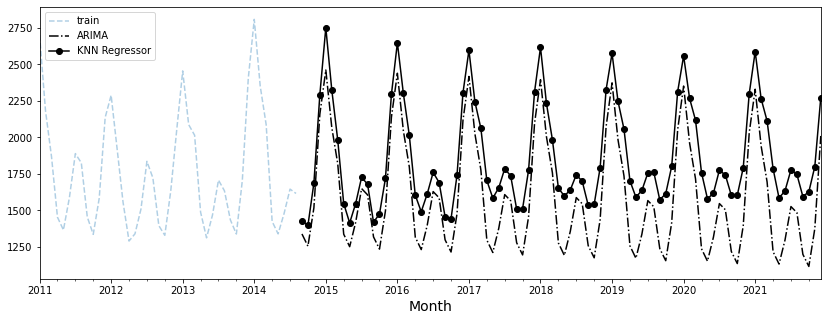

In [105]:
ax = train.loc['2011':].plot(style='--', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k-.')
test['K-NN Regressor'].plot(ax=ax, style='k-o')
# test['Naive Forecaster'].plot(ax=ax, style='.-')
plt.legend(['train', 'ARIMA', 'KNN Regressor'])
#plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.14.png', bbox_inches='tight', dpi=600)

## How it Works

```python
make_reduction(estimator, 
               strategy='recursive', 
               window_length=10, 
               scitype='infer')
```

# Recipe 5. Optimizing a Machine Learning model with Hyperparameter Tuning

In [106]:
from sktime.forecasting.all import (
        ForecastingGridSearchCV, 
        SlidingWindowSplitter,
        MeanAbsolutePercentageError)

In [107]:
df = energy.copy()

In [108]:
train, test = split_data(df)

In [109]:
test.shape

(88, 1)

In [110]:
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
     ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
     ("forecast",
            make_reduction(
                KNeighborsRegressor(),
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ), ),  ])

In [111]:
forecaster.fit(train.values)
test['KNN-Regressor'] = forecaster.predict(fh)

In [112]:
test.head()

,y,KNN-Regressor
Month,,
2014-09-01,1428.555,1404.930420
2014-10-01,1331.478,1400.715430
2014-11-01,1773.932,1733.417657
2014-12-01,2164.807,2333.941613
2015-01-01,2580.929,2777.382750


In [113]:
evaluate(test, train)

,sMAPE,MAPE,RMSE,MASE
KNN-Regressor,0.090378,0.097746,225.568315,0.751772


In [114]:
KNeighborsRegressor()

KNeighborsRegressor()

In [115]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__algorithm': 'auto',
 'forecast__estimator__leaf_size': 30,
 'forecast__estimator__metric': 'minkowski',
 'forecast__estimator__metric_params': None,
 'forecast__estimator__n

In [116]:
forecaster.get_params().keys()

dict_keys(['steps', 'deseasonalize', 'detrend', 'forecast', 'deseasonalize__model', 'deseasonalize__sp', 'detrend__forecaster__degree', 'detrend__forecaster__regressor', 'detrend__forecaster__with_intercept', 'detrend__forecaster', 'forecast__estimator__algorithm', 'forecast__estimator__leaf_size', 'forecast__estimator__metric', 'forecast__estimator__metric_params', 'forecast__estimator__n_jobs', 'forecast__estimator__n_neighbors', 'forecast__estimator__p', 'forecast__estimator__weights', 'forecast__estimator', 'forecast__transformers', 'forecast__window_length'])

In [117]:
# example grid search space
hyperparams_grid = {
    "forecast__estimator__n_neighbors": [i for i in range(3,11)],
    "deseasonalize__model": ['multiplicative', 'additive'],
    "forecast__estimator__p": [1,2]
}

In [118]:
cv = SlidingWindowSplitter(window_length=int(len(df) * 0.70), fh=fh)
smape = MeanAbsolutePercentageError(symmetric=True)

grid_csv = ForecastingGridSearchCV(
    forecaster, 
    strategy="refit", 
    cv=cv,
    param_grid=hyperparams_grid, 
    scoring=smape,
    return_n_best_forecasters=1,
    verbose=1
)

In [119]:
grid_csv.cv

SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relative=True),
           window_length=411)

In [120]:
fh

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relative=True)

In [121]:
grid_csv.fit(train.values, fh=fh)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relat...
                                                                       Detrender(forecaster=PolynomialTrendForecaster())),
                                                                      ('forecast',
                                                                       RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                                                                                            window_length=12))]),
                        param_grid={'deseasonalize__model': ['multiplicative',
                                                             'additive'],
                                    'forecast__estimator__n_neighbors': [3, 4,
                                                                         5, 6,
                                                                         7, 8,
                                                                         9,
                                                                         10],
                                    'forecast__estimator__p': [1, 2]},
                        scoring=MeanAbsolutePercentageError(), verbose=1)

In [122]:
grid_csv.best_forecaster_

TransformedTargetForecaster(steps=[('deseasonalize', Deseasonalizer(sp=12)),
                                   ('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                                                         window_length=12))])

In [123]:
grid_csv.best_params_

{'deseasonalize__model': 'additive',
 'forecast__estimator__n_neighbors': 7,
 'forecast__estimator__p': 2}

In [124]:
grid_csv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.068065,0.046526,0.087258,"{'deseasonalize__model': 'multiplicative', 'fo...",28.0
1,0.066450,0.028025,0.055551,"{'deseasonalize__model': 'multiplicative', 'fo...",24.0
2,0.065952,0.046414,0.110391,"{'deseasonalize__model': 'multiplicative', 'fo...",19.0
3,0.064853,0.048145,0.085701,"{'deseasonalize__model': 'multiplicative', 'fo...",11.0
4,0.064658,0.027496,0.046003,"{'deseasonalize__model': 'multiplicative', 'fo...",9.0
5,0.062486,0.039164,0.075235,"{'deseasonalize__model': 'multiplicative', 'fo...",2.0
6,0.064220,0.107171,0.205653,"{'deseasonalize__model': 'multiplicative', 'fo...",7.0
7,0.065216,0.040450,0.067389,"{'deseasonalize__model': 'multiplicative', 'fo...",14.0
8,0.066626,0.044329,0.088866,"{'deseasonalize__model': 'multiplicative', 'fo...",26.0
9,0.065606,0.036522,0.070379,"{'deseasonalize__model': 'multiplicative', 'fo...",15.0


In [125]:
test['KNN_optimized'] = grid_csv.predict(fh)

In [126]:
evaluate(test, train)

,sMAPE,MAPE,RMSE,MASE
KNN_optimized,0.088823,0.095325,188.102334,0.684741
KNN-Regressor,0.090378,0.097746,225.568315,0.751772


In [127]:
grid_csv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.068065,0.046526,0.087258,"{'deseasonalize__model': 'multiplicative', 'fo...",28.0
1,0.066450,0.028025,0.055551,"{'deseasonalize__model': 'multiplicative', 'fo...",24.0
2,0.065952,0.046414,0.110391,"{'deseasonalize__model': 'multiplicative', 'fo...",19.0
3,0.064853,0.048145,0.085701,"{'deseasonalize__model': 'multiplicative', 'fo...",11.0
4,0.064658,0.027496,0.046003,"{'deseasonalize__model': 'multiplicative', 'fo...",9.0
5,0.062486,0.039164,0.075235,"{'deseasonalize__model': 'multiplicative', 'fo...",2.0
6,0.064220,0.107171,0.205653,"{'deseasonalize__model': 'multiplicative', 'fo...",7.0
7,0.065216,0.040450,0.067389,"{'deseasonalize__model': 'multiplicative', 'fo...",14.0
8,0.066626,0.044329,0.088866,"{'deseasonalize__model': 'multiplicative', 'fo...",26.0
9,0.065606,0.036522,0.070379,"{'deseasonalize__model': 'multiplicative', 'fo...",15.0


In [128]:
model = grid_csv.best_forecaster_

In [129]:
model.get_params() 

{'steps': [('deseasonalize', Deseasonalizer(sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                      window_length=12),
 'deseasonalize__model': 'additive',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__algorithm': 'auto',
 'forecast__estimator__leaf_size': 30,
 'forecast__estimator__metric': 'minkowski',
 'forecast__estimator__metric_params': None,
 'forecast__estimator__n_jobs': None,
 'forecast__es

# Recipe 6. Multivariate Forecasting and Ensemble Learning with sktime

In [130]:
from sktime.forecasting.all import EnsembleForecaster
from sklearn.svm import SVR
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.datasets import load_macroeconomic

In [131]:
load_macroeconomic().shape

(203, 12)

In [132]:
econ = load_macroeconomic()
cols = ['realgdp','realdpi','tbilrate', 'unemp', 'infl']
econ_df = econ[cols]

In [133]:
econ_df.shape

(203, 5)

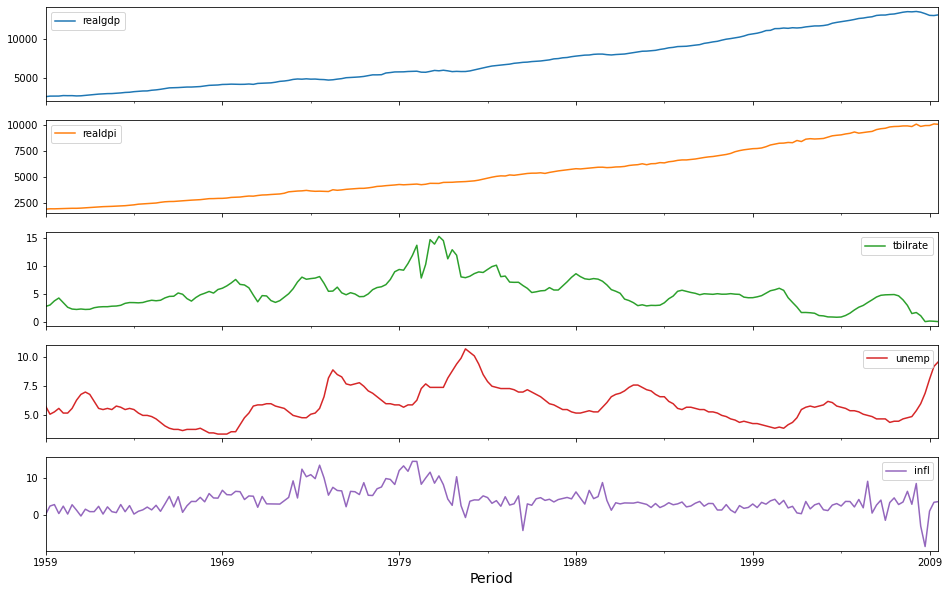

In [134]:
econ_df.plot(subplots=True, figsize=(16, 10));plt.show()

## How to do it

In [135]:
econ_df.head()

,realgdp,realdpi,tbilrate,unemp,infl
Period,,,,,
1959Q1,2710.349,1886.9,2.82,5.8,0.00
1959Q2,2778.801,1919.7,3.08,5.1,2.34
1959Q3,2775.488,1916.4,3.82,5.3,2.74
1959Q4,2785.204,1931.3,4.33,5.6,0.27
1960Q1,2847.699,1955.5,3.50,5.2,2.31


In [136]:
cond_deseason = ConditionalDeseasonalizer(sp=4)
detrend = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
for col in econ_df:
    econ_df[col] = cond_deseason.fit_transform(econ_df[col])
    econ_df[col] = detrend.fit_transform(econ_df[col])

In [137]:
y = econ_df['unemp']
exog = econ_df.drop(columns=['unemp'])

In [138]:
len(econ_df)*0.1

20.3

In [139]:
test_size = 0.1
y_train, y_test = split_data(y, test_split=test_size)
exog_train, exog_test = split_data(exog, test_split=test_size)

In [140]:
regressors = [
    ("LinearRegression", make_reduction(LinearRegression())),
    ("RandomForest", make_reduction(RandomForestRegressor())),
    ("SupportVectorRegressor", make_reduction(SVR())),
    ("GradientBoosting", make_reduction(GradientBoostingRegressor()))]

In [141]:
ensemble = EnsembleForecaster(regressors)
naive = NaiveForecaster()

In [142]:
ensemble.fit(y=y_train, X=exog_train)
naive.fit(y=y_train, X=exog_train)

NaiveForecaster()

In [143]:
fh = ForecastingHorizon(y_test.index, is_relative=None)

y_hat = pd.DataFrame(y_test).rename(columns={'unemp': 'test'})
y_hat['EnsembleForecaster'] = ensemble.predict(fh=fh, X=exog_test)
y_hat['NaiveForecaster'] = naive.predict(fh=fh, X=exog_test)

In [144]:
y_hat.rename(columns={'test':'y'}, inplace=True)

In [145]:
evaluate(y_hat, y_train)

,sMAPE,MAPE,RMSE,MASE
NaiveForecaster,0.946033,2.490779,1.537844,4.522654
EnsembleForecaster,1.303669,1.096867,1.372753,4.635079


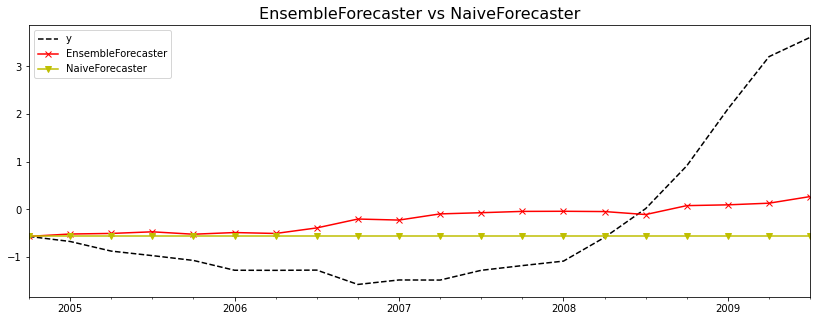

In [146]:
styles = ['k--','rx-','yv-']
for col, s in zip(y_hat, styles):
    y_hat[col].plot(style=s, label=col, 
                    title='EnsembleForecaster vs NaiveForecaster')
plt.legend()
#plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.18.png', bbox_inches='tight', dpi=600)

## There is more

In [147]:
regressors

[('LinearRegression',
  RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
 ('RandomForest',
  RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
 ('SupportVectorRegressor',
  RecursiveTabularRegressionForecaster(estimator=SVR())),
 ('GradientBoosting',
  RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))]

In [148]:
from sktime.forecasting.compose import AutoEnsembleForecaster

auto = AutoEnsembleForecaster(forecasters=regressors,
                             method='feature-importance')
auto.fit(y=y_train, X=exog_train)

AutoEnsembleForecaster(forecasters=[('LinearRegression',
                                     RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
                                    ('RandomForest',
                                     RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
                                    ('SupportVectorRegressor',
                                     RecursiveTabularRegressionForecaster(estimator=SVR())),
                                    ('GradientBoosting',
                                     RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))])

In [149]:
auto.weights_

[0.040031436269936396,
 0.3247853141460731,
 0.2524596962183177,
 0.38272355336567276]

In [150]:
y_hat['AutoEnsembleForecaster'] = auto.predict(fh=fh, X=exog_test)

In [151]:
evaluate(y_hat, y_train)

,sMAPE,MAPE,RMSE,MASE
NaiveForecaster,0.946033,2.490779,1.537844,4.522654
EnsembleForecaster,1.303669,1.096867,1.372753,4.635079
AutoEnsembleForecaster,1.460157,0.856270,1.464763,4.987110
